<a href="https://colab.research.google.com/github/pauloigorms/covid-twitter-pecd/blob/main/Programacao_Ciencia_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROGRAMAÇÃO PARA CIÊNCIA DE DADOS**

**Equipe**: Cássio de Paula / Paulo Moraes [(website)](https://paulomoraes.me).

**Objetivo**: *analisar as mensagens
trocadas por usuários do Twitter sobre a COVID-19, com o intuito de realizar uma análise
exploratória e visualização de dados, passando também pelas etapas de limpeza e organização.
Mais especificamente, as equipes devem explorar a análise nas perguntas (questões) dos usuários,
pois arguimos que seja um tipo de mensagem apropriado para se compreender as principais dúvidas
das pessoas sobre a atual pandemia.*


# **INFORMAÇÕES GERAIS**


**ARTEFATOS**

*   Relatório Técnico - *Um notebook com o texto e o código-fonte apresentado na ferramenta Google COLAB*; 
*   Repositório no GitHub.


**ATIVIDADES**

*   Importar base de dados;
*   Tratar base de dados;
*   Identificar as perguntas (questões) descritas nas mensagens;
*   Salvar coleção com a identificação das perguntas em um novo dataset chamado "DuvidasDB".


**DO RESULTADO**

1.   Devem apresentar um resumo (sumário) com as estatísticas dos dados originais, elas podem ser apresentadas através de tabelas e/ou gráficos;
2.   Com a coleção resultando da identificação das perguntas a equipe deve apresentar as estatísticas sobre estes dados.


**TEMAS DISCUTIDOS**

As equipes devem fazer uma análise sobre os temas que são debatidos nas perguntas dos postadas pelos usuários. Faça uma análise se as perguntas são relativas aos seguintes temas:

*   Doença. Quando a pergunta é relativa à doença Deve-se observar que a doença é identificada por vários nomes. Exemplo: coronavírus, corona, COVID-19, etc;
*   Medicamento. Quando a pergunta é sobre o uso de determinado medicamento no tratamento da doença;
*   Organizações. Quando a pergunta é relativa a uma determinada entidade ou organização. Emissora de TV, Ministério da Saúde ou empresas são exemplos de organizações;
*   Pessoas. Quando a pergunta é sobre determinada pessoa. Por exemplo, a pergunta pode ser sobre a atuação que determinado político ou pessoa famosa teve durante esse período de pandemia.



**VISÃO DOS DADOS**

> **Visão Temporal** - Deve-se fazer uma análise temporal das perguntas que formam o dataset *DuvidasDB*. Pode-se considerar o intervalo temporal de dias, semanas ou meses. A escolha do intervalo de tempo ficará a cargo das equipes. Exemplos de análise temporal: a) houve um aumento no número de perguntas
ao longo do tempo? b) houve uma mudança no perfil das perguntas ao longo do tempo?

> **Visão Geográfica** - Deve-se fazer uma análise geográfica (espacial) das perguntas que formam o dataset *DuvidasDB*. Existem algumas colunas no dataset que trazem a informação das localizações como, por exemplo, o país, estado e cidade. Em alguns tuítes é possível ainda identificar as coordenadas geográficas
de latitude e longitude. Exemplo de análise geográfica: a) os usuários de regiões diferentes fazem
perguntas com diferentes focos? Por exemplo, será que os usuários de uma região perguntam mais
sobre a doença ou sobre o tratamento? Essa análise ainda pode ser realizada em diversos níveis de
área (cidade, estado ou região). Além de apresentar a distribuição das dúvidas dos usuários por
região, a equipe deverá fazer uma análise dessa distribuição. Por exemplo, apresentar as razões
(ou hipóteses) da ocorrência dessa distribuição.

# **INICIANDO O PROJETO**

IMPORTANDO LIBS

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import nltk as nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from nltk.stem import rslp

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import PCA

import re as rexpression
import sys
from string import punctuation
import unicodedata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


LEITURA DO ARQUIVO DE DADOS BASE

In [191]:
drive.mount('/content/drive')
load_data = pd.read_csv('drive/My Drive/twitter/dados-curso-completo.csv', sep= ',',skiprows=0, encoding='utf-8')

duvidas_file = pd.read_csv('drive/My Drive/twitter/duvidasdb.csv', sep= ',',skiprows=0, encoding='utf-8')
texto_classificado = pd.read_csv('drive/My Drive/twitter/texto_classificado_v1.csv', sep= ',',skiprows=0, encoding='utf-8')

raw_data = load_data.drop_duplicates(['texto'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **ESTATÍSTICAS BASES**


**Exemplo da base de dados**

---



In [192]:
raw_data.head(1)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]


In [193]:
raw_data.dtypes

data           object
usuario        object
apelido        object
texto          object
retweet         int64
seguidores      int64
idioma         object
lugar          object
pais           object
sigla          object
latitude      float64
longitude     float64
hashtags       object
dtype: object

**Tamanha da base (com e sem dados duplicados)**

---

In [194]:
print("Total de dados (com duplicados): ", decimaled(load_data.texto.count()), " completo[", load_data.texto.count(), "]" )

Total de dados (com duplicados):  1.66M  completo[ 1658825 ]


In [195]:
print("Total de dados (sem duplicados): ", decimaled(raw_data.texto.count()), " completo[", raw_data.texto.count(), "]" )

Total de dados (sem duplicados):  1.65M  completo[ 1653599 ]


**Twitters por região**

---

In [196]:
print("Total de twitters com localização: ", decimaled(raw_data['lugar'].count()), " completo[", raw_data['lugar'].count(),"]")

Total de twitters com localização:  74.4K  completo[ 74383 ]


In [197]:
print("Percentual em relação à base: ", percentual(value=raw_data['lugar'].count(), total=raw_data.texto.count()))

Percentual em relação à base:  4.50%


In [198]:
raw_data[raw_data.pais == 'Brazil'].groupby('pais').count()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,sigla,latitude,longitude,hashtags
pais,,,,,,,,,,,,
Brazil,67034,67033,67034,67034,67034,67034,67034,67034,67034,7675,7675,67034


In [199]:
raw_data[raw_data.pais == 'Brazil'].groupby(['pais', 'lugar']).count().tail(2)

data  usuario  apelido  ...  latitude  longitude  hashtags
pais   lugar                                  ...                               
Brazil Érico Cardoso     1        1        1  ...         1          1         1
       Óbidos            2        2        2  ...         0          0         2

[2 rows x 11 columns]

**Twitters por período**

---

In [200]:
df_data = pd.DataFrame(raw_data)
df_data['data'] = pd.to_datetime(df_data['data'])
dt_format = df_data
df_data.index = df_data['data']
df_data.drop('data', inplace=True, axis=1)

df_res = df_data.resample('M').count()
df_res.reset_index(inplace=True)

df_res

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-01-31,54388,54391,54391,54391,54391,54391,2177,2177,2177,80,80,54391
1,2020-02-29,109485,109489,109489,109489,109489,109489,4305,4305,4305,225,225,109489
2,2020-03-31,480112,480128,480128,480128,480128,480128,23487,23486,23484,2561,2561,480128
3,2020-04-30,469321,469334,469334,469334,469334,469334,21318,21317,21315,2516,2516,469334
4,2020-05-31,283219,283229,283229,283229,283229,283229,12780,12777,12777,1993,1993,283229
5,2020-06-30,257022,257027,257027,257027,257027,257027,10316,10316,10315,1345,1345,257027
6,2020-07-31,1,1,1,1,1,1,0,0,0,0,0,1


Text(0, 0.5, 'Mês 2020')

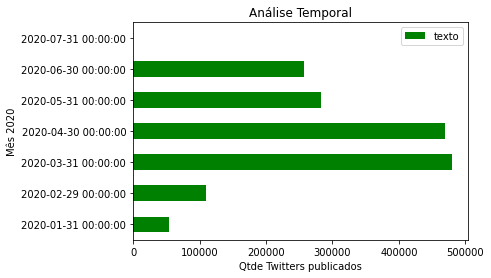

In [201]:
graph = df_res.plot(kind='barh',x='data',y='texto', title="Análise Temporal", color="green")
graph.set_xlabel("Qtde Twitters publicados")
graph.set_ylabel("Mês 2020")

**Twitters por Hashtag**

---

In [301]:
raw_data[raw_data.pais == "Brazil"].groupby('hashtags').count().head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: ignored

**Hashtags**

---

In [ ]:
master_tags = []
#for index, item in raw_data.iterrows():
#  master_tags = master_tags + item.hashtags.strip('][').split(', ') 

raw_data[raw_data.hashtags.str.contains("corona")].count()

# **PROCESSAMENTO**

**MINERANDO PERGUNTAS**


Extraindo perguntas

In [ ]:
twitter = []
perguntas = []
erro = []
for i in range(0, len(raw_data)):
  try:
    twitter.append(sent_tokenize(raw_data[i]))   #twitter é uma lista de frases/sentenças
    for sentencas in twitter: #percorro todas as sentenças
      for row in sentencas:
        palavras = word_tokenize(row.lower()) #quebra a sentença em palavras e pontuações
        for palavra in palavras:
          if palavra == '?':
            perguntas.append([row,i]) 
            break #em uma senteça pode ter vario pontos de interrogação, então logo no primeiro '?' ele recupera a sentença e sai dessa iteração
    twitter.clear()#libera a lista de sentenças atual/ pois o objetivo era apenas percorrer o registro e não persistir o twitter a cada iteração 
  except:
    erro.append(i)

# ARMAZENANDO EM CSV
# df_DuvidasDB = pd.DataFrame(perguntas, columns=['Perguntas','Indice'])
# df_DuvidasDB.to_csv(r'drive/My Drive/twitter/duvidasdb.csv', index = False)

Classificando perguntas

In [ ]:
medicamentos = ['cloroquina', 'hidroxicloroquina', 'cha','boldo', 'alho', 'remdesivir', 'azitromicina', 'remedio', 'remédio', 'vitamina', 'chá','sopa','fitoterápicos','alopáticos','ansiolíticos','passiflora','melissa','camomila'] 
pessoas = ['bolsonarosp', 'henrique', 'mandetta', 'eduardo', 'pazuello', 'jair', 'bolsonaro', 'Nelson', 'Teich', 'atila', 'iamarino', 'paulo', 'guedes', 'donald', 'trump', 'mandetta','doria', 'Wilson', 'Witzel','Ronaldo','Caiado','Camilo','Santana','Gladson', 'Cameli','Renan','Rui', 'Ibaneis', 'Renato', 'Casagrande','Mauro','Mendes','Reinaldo', 'Azambuja']
doencas = ['corona','corona virus', 'virus', 'pandemia', 'epidemia', 'covid', 'covid-19', 'coronavírus','artrite','gripe','gripezinha','resfriado', 'srag', 'asma','doença','tosse','febre','dor','uti','leitos','câncer', 'diabetes','VIH']
organizacoes = ['globo', 'tvglobo', 'cnn', 'ministerio da saude', 'stf', 'estadao', 'folha de sao paulo', 'isto é', 'pan', 'jp', 'jornal', 'tv', 'radio','facebook', 'twitter', 'jornal da globo', 'ministério', 'onu','sbt','oms']


In [ ]:
#classificação por grupos distintos
desclassi = []
perguntas_class = []
erro_class = []
for i in range(0, len(duvidas_file['Perguntas'])):
  try:
    desclassi.append(sent_tokenize(duvidas_file['Perguntas'][i]))   
    for sentencas in desclassi: 
      for row in sentencas:
        palavras = word_tokenize(row.lower()) 
        palavras.reverse()
        for palavra in palavras:
          if palavra in medicamentos:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,1]) 
            break 
          if palavra in pessoas:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,2]) 
            break 
          if palavra in doencas:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,3]) 
            break  
          if palavra in organizacoes:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,4]) 
            break        
    desclassi.clear()
  except:
    erro_class.append(i)

#df_DuvidasDBTema = pd.DataFrame(perguntas_class, columns=['Perguntas','Indice','Tema'])
#df_DuvidasDBTema.to_csv(r'drive/My Drive/twitter/duvidasdbClassi.csv', index = False)

In [ ]:
#classificação interseções de grupos
desclassi = []
perguntas_class = []
erro_class = []
for i in range(0, len(duvidas_file['Perguntas'])):
  try:
    desclassi.append(sent_tokenize(duvidas_file['Perguntas'][i]))   
    for sentencas in desclassi: 
      for row in sentencas:
        palavras = word_tokenize(row.lower()) 
        palavras.reverse()
        for palavra in palavras:
          if palavra in medicamentos:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,1]) 
            break 
        for palavra in palavras:    
          if palavra in pessoas:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,2]) 
            break 
        for palavra in palavras:    
          if palavra in doencas:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,3]) 
            break 
        for palavra in palavras:     
          if palavra in organizacoes:
            perguntas_class.append([duvidas_file['Perguntas'][i],i,4]) 
            break        
    desclassi.clear()
  except:
    erro_class.append(i)

In [ ]:
#df_DuvidasDBTema = pd.DataFrame(perguntas_class, columns=['Perguntas','Indice','Tema'])
#df_DuvidasDBTema.to_csv(r'drive/My Drive/twitter/duvidasdbClassiInters.csv', index = False)

# **ANALISANDO A CLASSIFICAÇÃO**

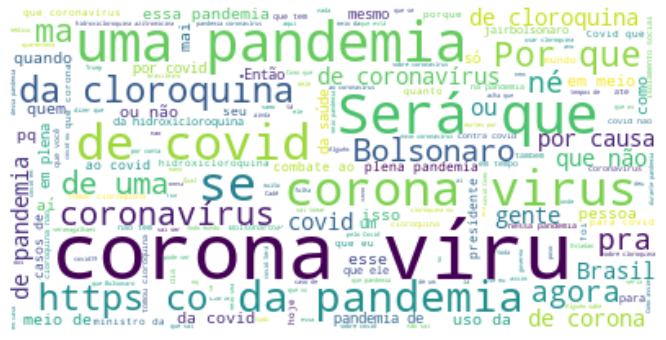

In [ ]:
perguntas = " ".join(twitter for twitter in texto_classificado.Perguntas)
wordcloud = WordCloud(background_color="white").generate(perguntas)
plt.figure(figsize=(13,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [281]:
texto_classificado['data'] = np.nan
texto_classificado['pais'] = np.nan
texto_classificado['usuario'] = np.nan
texto_classificado['retweet'] = np.nan
texto_classificado['seguidores'] = np.nan

for index in range(0, 2000):
  texto_classificado.loc[index, 'data'] = raw_data.iloc[index]['data']
  texto_classificado.loc[index, 'pais'] = raw_data.iloc[index]['pais']
  texto_classificado.loc[index, 'usuario'] = raw_data.iloc[index]['usuario']
  texto_classificado.loc[index, 'retweet'] = raw_data.iloc[index]['retweet']  
  texto_classificado.loc[index, 'seguidores'] = raw_data.iloc[index]['seguidores']

texto_classificado['data'] = pd.to_datetime(texto_classificado['data']).dt.strftime('%m-%Y')

In [282]:
texto_classificado.head(5)

,Perguntas,Indice,Tema,data,pais,usuario,retweet,seguidores
0,@BolsonaroSP Cade o fundão deputado???,0,2,03-2020,NaN,Gaboardi,0.0,138.0
1,Fumaça de cigarro pode propagar coronavírus?,1,3,03-2020,NaN,Seu Zé da Farmácia,0.0,56.0
2,@JoseMedeirosMT Seria isso algum tipo aleatóri...,5,3,03-2020,NaN,Marília Oliveira 🇧🇷,0.0,5.0
3,"""Nova York é o novo epicentro da pandemia de c...",6,3,04-2020,NaN,🚩,0.0,1885.0
4,@mitags Será por que o Bolsonaro não fez propa...,7,2,03-2020,Brazil,Nova Impressão,0.0,124.0


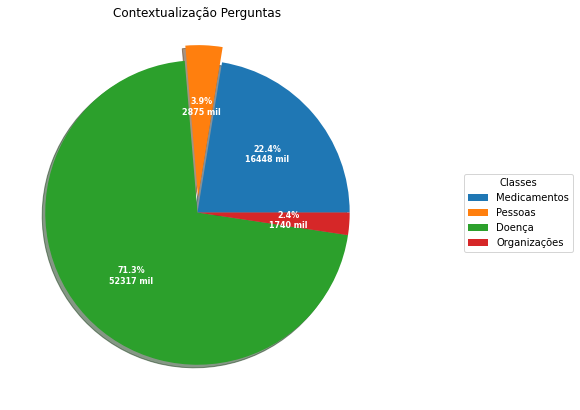

In [300]:
classes = texto_classificado.groupby('Tema').count().Perguntas

# gerando dados para gráfico
tags = ['Medicamentos', 'Pessoas', 'Doença', 'Organizações']
dados = [classes[1], classes[2], classes[3], classes[4]]

# definir área em destaque
espaco = (0, 0.1, 0, 0)

# criando representação gráfica
fig1, pizza = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect='equal'))

# definir cores
cores = ['#9c27b0', '#e91e63', '#3f51b5', '#7b1fa2']

# gráfico pizza
wedges, texts, autotexts = pizza.pie(dados, explode=espaco, shadow=True, labels=tags, autopct=lambda pct: legenda(pct, dados), textprops=dict(color="w"))
pizza.legend(wedges, tags, title='Classes', loc='center right', bbox_to_anchor=(1, 0, 0.5, 1))

pizza.set_title("Contextualização Perguntas")
plt.setp(autotexts, size=8, weight="bold")

# apresenta gráfico
plt.show()

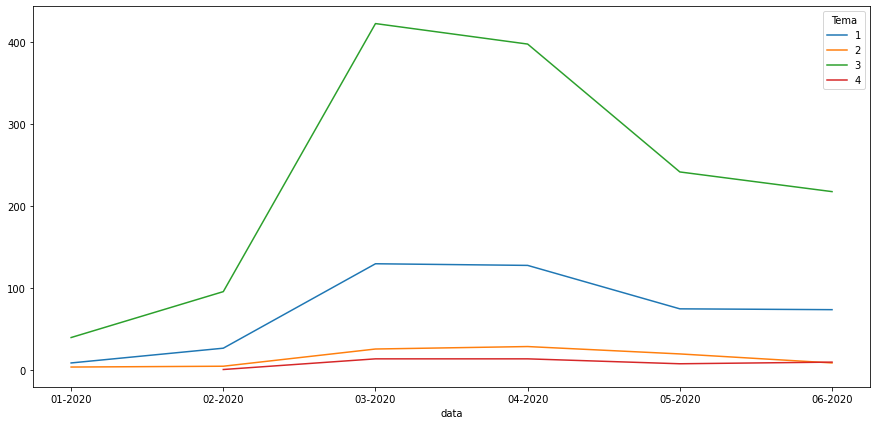

In [293]:
fig, ax = plt.subplots(figsize=(15,7))
texto_classificado.groupby(['data', 'Tema']).count()['Perguntas'].unstack().plot(ax=ax)

# **I.A?**

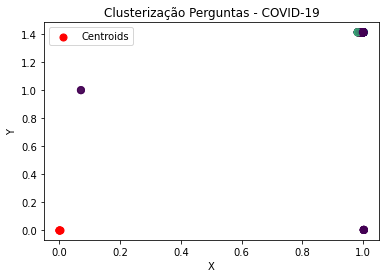

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True)
vectorizer = vectorizer.fit_transform(text_processed)

kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 30).fit(vectorizer)
predict = kmeans.predict(vectorizer)

labels = kmeans.labels_
distance = kmeans.fit_transform(vectorizer)

plt.scatter(distance[:, 0], distance[:,1], s = 50, c = labels, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, c = 'red', label = 'Centroids')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, color = 'black', alpha=0.5)
plt.title('Clusterização Perguntas - COVID-19')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Funções públicas

Função: **Cálcular Percente**

In [ ]:
def percentual(value, total):
    if not value and not total: 
       return print("value = 0% \n total = 0%") 
    elif value < 0 or total < 0: 
       return print("não aceita valor negativo!") 
    else: 
       return '{0:.2f}%'.format((value / total * 100))

Função: **Formatar para configuração decimal**

In [294]:
def decimaled(value):
  value = float('{:.3g}'.format(value))
  size = 0
  while abs(value) >= 1000:
    size += 1
    value /= 1000.0
  return '{}{}'.format('{:f}'.format(value).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][size])

Função: **Tokenização**

In [ ]:
 def tokenize(sentence):
  words = sentence.split()
  tclean = []
  for word in words:
    nfkd = unicodedata.normalize('NFKD', word)
    noaccent = u''.join([r for r in nfkd if not unicodedata.combining(r)])
    join = rexpression.sub('[^a-zA-Z \\\]',' ', noaccent)
    tclean.append(join.lower().strip())
  return ' '.join([r for r in tclean if len(r) > 1 and not r.isdigit()])

Função: **Remover stopwords**

In [ ]:
def rm_stopwords(sentence):
  words = sentence.split()
  swords = stopwords.words('portuguese')
  return [r for r in words if r.lower().strip() not in swords] 

Função: **Reduzir as palavras ao seu radical**

In [ ]:
def stemming(words):
  stm = []
  for word in words:
    stm.append(rslp.RSLPStemmer().stem(word))
  return stm

Função: **Mineração de texto**

In [ ]:
def mining_text(frame):
  result = []
  for index, question in frame.iterrows():
    item = tokenize(question.Perguntas)
    item = rm_stopwords(item)
    #item = stemming(item)
    result.append(item)
  return result

Função: **Gerar legenda**

In [299]:
def legenda(pct, valores):
  resultado = int(pct/100.*np.sum(valores))
  return '{:.1f}%\n{:d} mil'.format(pct, resultado)